# Рекуррентные нейросети

Построим простейшую нейросеть для посимвольной генерации текста

In [1]:
import pandas as pd  # для работы с данными
import time  # для оценки времени
import torch  # для написания нейросети

from torch import nn

import gc

In [140]:
from IPython.display import Image

## Загрузка данных

Будем работать с датасетом реплик из Симпсонов. Нам нужно извлечь предобработанные тексты и закодировать их числами

In [2]:
df = pd.read_csv('../simpsons_script_lines.csv')
df.head()

/tmp/ipykernel_125516/696996245.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../simpsons_script_lines.csv')


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33


In [3]:
phrases = df['normalized_text'].tolist()  # колонка с предобработанными текстами
phrases[:10]

['no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it',
 'wheres mr bergstrom',
 'i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you',
 'that life is worth living',
 'the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this well have our final statements martin',
 'i dont think theres anything left to say',
 'bart',
 'victory party under the slide',
 nan,
 'mr bergstrom mr bergstrom']

In [4]:
text = [[c for c in ph] for ph in phrases if type(ph) is str]

## Создаём массив с данными

Нужно

1. Разбить данные на токены (у нас символы)
2. Закодировать числами
3. Превратить в эмбеддинги

In [5]:
CHARS = set('abcdefghijklmnopqrstuvwxyz ')  # все символы, которые мы хотим использовать для кодировки = наш словарь
INDEX_TO_CHAR = ['none'] + [w for w in CHARS]  # все неизвестные символы будут получать тег none
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}  # словарь токен-индекс

In [6]:
len(INDEX_TO_CHAR)

28

In [7]:
print(INDEX_TO_CHAR)

['none', 'u', ' ', 'e', 'f', 'z', 'q', 'v', 'j', 'w', 'r', 'i', 'x', 'a', 'o', 'c', 'g', 'p', 'n', 's', 'y', 'd', 'k', 'l', 't', 'm', 'h', 'b']


In [8]:
print(CHAR_TO_INDEX)

{'none': 0, 'u': 1, ' ': 2, 'e': 3, 'f': 4, 'z': 5, 'q': 6, 'v': 7, 'j': 8, 'w': 9, 'r': 10, 'i': 11, 'x': 12, 'a': 13, 'o': 14, 'c': 15, 'g': 16, 'p': 17, 'n': 18, 's': 19, 'y': 20, 'd': 21, 'k': 22, 'l': 23, 't': 24, 'm': 25, 'h': 26, 'b': 27}


In [9]:
IND2CHAR =  { v:k for k,v in CHAR_TO_INDEX.items()}
print(IND2CHAR)

{0: 'none', 1: 'u', 2: ' ', 3: 'e', 4: 'f', 5: 'z', 6: 'q', 7: 'v', 8: 'j', 9: 'w', 10: 'r', 11: 'i', 12: 'x', 13: 'a', 14: 'o', 15: 'c', 16: 'g', 17: 'p', 18: 'n', 19: 's', 20: 'y', 21: 'd', 22: 'k', 23: 'l', 24: 't', 25: 'm', 26: 'h', 27: 'b'}


In [10]:
MAX_LEN = 50  # мы хотим ограничить максимальную длину ввода
X = torch.zeros((len(text), MAX_LEN), dtype=int)  # создаём пустой вектор для текста, чтобы класть в него индексы токенов
for i in range(len(text)):  # для каждого предложения
    for j, w in enumerate(text[i]):  # для каждого токена
        if j >= MAX_LEN:
            break
        X[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

In [11]:
print(len(X))

132087


In [12]:
batch = X[0:5]
print(batch, batch.shape)
# print(btch[:,:-1], btch[:,:-1].shape)
# print(btch[:,1:], btch[:,1:].shape)

tensor([[18, 14,  2, 13, 15, 24,  1, 13, 23, 23, 20,  2, 11, 24,  2,  9, 13, 19,
          2, 13,  2, 23, 11, 24, 24, 23,  3,  2, 14,  4,  2, 27, 14, 24, 26,  2,
         19, 14, 25,  3, 24, 11, 25,  3, 19,  2,  9, 26,  3, 18],
        [ 9, 26,  3, 10,  3, 19,  2, 25, 10,  2, 27,  3, 10, 16, 19, 24, 10, 14,
         25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [11,  2, 21, 14, 18, 24,  2, 22, 18, 14,  9,  2, 13, 23, 24, 26, 14,  1,
         16, 26,  2, 11, 21,  2, 19,  1, 10,  3,  2, 23, 11, 22,  3,  2, 24, 14,
          2, 24, 13, 23, 22,  2, 24, 14,  2, 26, 11, 25,  2, 26],
        [24, 26, 13, 24,  2, 23, 11,  4,  3,  2, 11, 19,  2,  9, 14, 10, 24, 26,
          2, 23, 11,  7, 11, 18, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [24, 26,  3,  2, 17, 14, 23, 23, 19,  2,  9, 11, 23, 23,  2, 27,  3,  2,
       

In [13]:
import numpy as np
# arr = np.zeros((len(btch),50))
arr = []
for i in range(len(batch[:, 1:])):
    row = []
    for j in range(len(batch[:, 1:][0])):
        if IND2CHAR[batch[:, 1:][i,j].item()] == 'none':
            break
        else:
            row.append(IND2CHAR[batch[:, 1:][i,j].item()])
#         arr[i,j] = IND2CHAR[btch[i,j].item()]
    arr.append(row)
print(arr)

[['o', ' ', 'a', 'c', 't', 'u', 'a', 'l', 'l', 'y', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'a', ' ', 'l', 'i', 't', 't', 'l', 'e', ' ', 'o', 'f', ' ', 'b', 'o', 't', 'h', ' ', 's', 'o', 'm', 'e', 't', 'i', 'm', 'e', 's', ' ', 'w', 'h', 'e', 'n'], ['h', 'e', 'r', 'e', 's', ' ', 'm', 'r', ' ', 'b', 'e', 'r', 'g', 's', 't', 'r', 'o', 'm'], [' ', 'd', 'o', 'n', 't', ' ', 'k', 'n', 'o', 'w', ' ', 'a', 'l', 't', 'h', 'o', 'u', 'g', 'h', ' ', 'i', 'd', ' ', 's', 'u', 'r', 'e', ' ', 'l', 'i', 'k', 'e', ' ', 't', 'o', ' ', 't', 'a', 'l', 'k', ' ', 't', 'o', ' ', 'h', 'i', 'm', ' ', 'h'], ['h', 'a', 't', ' ', 'l', 'i', 'f', 'e', ' ', 'i', 's', ' ', 'w', 'o', 'r', 't', 'h', ' ', 'l', 'i', 'v', 'i', 'n', 'g'], ['h', 'e', ' ', 'p', 'o', 'l', 'l', 's', ' ', 'w', 'i', 'l', 'l', ' ', 'b', 'e', ' ', 'o', 'p', 'e', 'n', ' ', 'f', 'r', 'o', 'm', ' ', 'n', 'o', 'w', ' ', 'u', 'n', 't', 'i', 'l', ' ', 't', 'h', 'e', ' ', 'e', 'n', 'd', ' ', 'o', 'f', ' ', 'r']]


## Embedding и RNN ячейки

Каждому токену мы хотим сопоставить не просто число, но вектор. Поэтому вектор текста нам нужно умножить на матрицу эмбеддингов, которая тоже будет учиться в процессе обучения нейросети. Для создания такой матрицы нам нужен слой `nn.Embedding`

In [14]:
X[0:5].shape

torch.Size([5, 50])

In [15]:
embeddings = torch.nn.Embedding(len(INDEX_TO_CHAR), 28)  # размер словаря * размер вектора для кодировки каждого слова
t = embeddings(X[0:5])
t.shape

torch.Size([5, 50, 28])

In [16]:
t.shape, X[0:5].shape

(torch.Size([5, 50, 28]), torch.Size([5, 50]))

In [17]:
rnn = torch.nn.RNN(28, 128, batch_first=True)  # на вход - размер эмбеддинга, размер скрытого состояния и порядок размерностей
with torch.no_grad():
    o, s = rnn(t)
# вектора для слов: батч * число токенов * размер скрытого состояния
# вектор скрытого состояния: число вектров (один) * батч * размер скрытого состояния
print(o.shape, s.shape)

torch.Size([5, 50, 128]) torch.Size([1, 5, 128])


Можно применять несколько рекуррентных ячеек подряд

In [18]:
o2, s2 = rnn(t, s)
o2.shape, s2.shape

(torch.Size([5, 50, 128]), torch.Size([1, 5, 128]))

## Реализация сети с RNN
3 слоя:
1. Embeding (30)
2. RNN (hidden_dim=128)
3. Полносвязный слой для предсказания буквы (28, то есть размер словаря)

# 1. Заменим "коробочный" модуль torch.nn.RNN на собственную реализацию (упрощенную), использующую полносвязные модули torch.nn.Linear

In [19]:
# class Network(torch.nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()
#         self.embedding = torch.nn.Embedding(28, 30)
#         self.rnn = torch.nn.RNN(30, 128)
#         self.out = torch.nn.Linear(128, 28)

#     def forward(self, sentences, state=None):
#         x = self.embedding(sentences)
#         x, s = self.rnn(x) # берём выход с последнего слоя для всех токенов, а не скрытое состояние
#         return self.out(x)

In [86]:
class RNN_emu(torch.nn.Module):
    def __init__(self,input_size, hidden_size, batch_first = False):
        super(RNN_emu, self).__init__()
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
#         self.hidden2output = nn.Linear(hidden_size, output_size)
    
    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)
    
    def forward(self,input_tensor):
        if len(input_tensor.shape) == 2: #IF SOMEHOW A SINGLE SEQUENCE OF FEATURE TENSORS IS PASSED AS ARGUMENT
            input_tensor = input_tensor.unsqueeze(1)
        if self.batch_first:
            input_tensor = input_tensor.permute(1,0,2)
        batch_size = input_tensor.shape[1]
        hidden = self.initHidden(batch_size)
        if input_tensor.is_cuda: ## IMPORTANT TO AVOID DEVICE CONFLICT
            hidden = hidden.cuda()
        hidden_all = []
        for X in input_tensor:
            hidden = self.input2hidden(X) + self.hidden2hidden(hidden)
            hidden = torch.tanh(hidden)
            hidden_all.append(hidden)
        hidden_all = torch.stack(hidden_all, dim=0)
        if self.batch_first:
            hidden_all = hidden_all.permute(1,0,2)
        return hidden_all, hidden.unsqueeze(0)

In [87]:
rnn_emu = RNN_emu(28, 128, batch_first=True)
# rnn_emu = RNN_emu(3, 2, batch_first=True)

In [88]:
# rnn = torch.nn.RNN(3, 2, batch_first=True)
# with torch.no_grad():
#     o, s = rnn(t)
# o.shape, s.shape

# 2. Проверим, что самодельный модуль возвращает те же объекты, что и "коробочный"

In [89]:
print(rnn_emu.state_dict().keys())
print(rnn.state_dict().keys())

odict_keys(['input2hidden.weight', 'input2hidden.bias', 'hidden2hidden.weight', 'hidden2hidden.bias'])
odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])


## 2.1 Перед тем, как провести входной объект через наш модуль, передадим ему все параметры (случайные, пока не обученные), которые получил при инициализации модуль torch.nn.RNN

In [90]:
rnn_emu.load_state_dict(dict(zip(rnn_emu.state_dict().keys(),
                                 [list(rnn.state_dict().values())[i] for i in [0,2,1,3]])))

<All keys matched successfully>

## 2.2 Проверим размерности возвращаемых объектов ...

In [91]:
with torch.no_grad():
    oe, se = rnn_emu(t)
oe.shape, se.shape

(torch.Size([5, 50, 128]), torch.Size([1, 5, 128]))

## 2.3 ... и равенство самих объектов, полученным ранее

In [92]:
(o == oe).all()

tensor(True)

In [93]:
(s == se).all()

tensor(True)

# 3. Попробуем также построить аналогичный модуль, но использующий вместо двух линейных слоев для скрытого состояния и входного тензора - один, эквивалентный им, с применением конкатенации

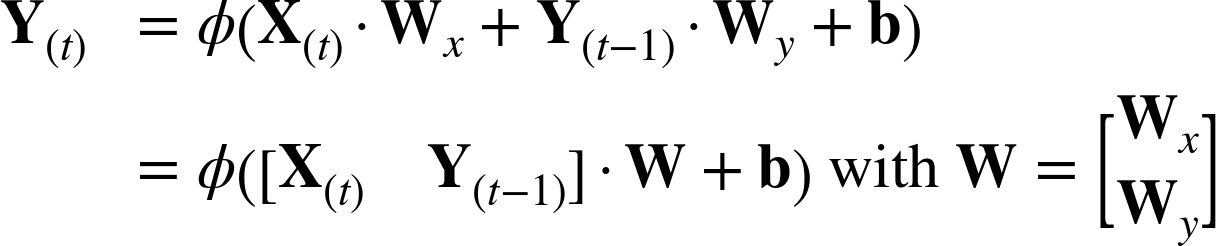

In [141]:
Image('https://www.oreilly.com/api/v2/epubs/9781492037354/files/assets/eq_30.png')

## .. единственное, у нас два вектора смещения _b_, но они просто суммируются

In [94]:
class RNN_emu_concat(torch.nn.Module):
    def __init__(self,input_size, hidden_size, batch_first = False):
        super(RNN_emu_concat, self).__init__()
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.input2hidden = nn.Linear(input_size + hidden_size, hidden_size)
#         self.hidden2output = nn.Linear(hidden_size, output_size)
    
    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)
    
    def forward(self,input_tensor):
        if len(input_tensor.shape) == 2: #IF SOMEHOW A SINGLE SEQUENCE OF FEATURE TENSORS IS PASSED AS ARGUMENT
            input_tensor = input_tensor.unsqueeze(1)
        if self.batch_first:
            input_tensor = input_tensor.permute(1,0,2)
        batch_size = input_tensor.shape[1]
        hidden = self.initHidden(batch_size)
        if input_tensor.is_cuda:
            hidden = hidden.cuda()
        hidden_all = []
        for X in input_tensor:
            hidden = self.input2hidden(torch.cat((X, hidden), 1))
            hidden = torch.tanh(hidden)
            hidden_all.append(hidden)
        hidden_all = torch.stack(hidden_all, dim=0)
        if self.batch_first:
            hidden_all = hidden_all.permute(1,0,2)
        return hidden_all, hidden.unsqueeze(0)

In [95]:
rnn_emu_concat = RNN_emu_concat(28, 128, batch_first=True)
# rnn_emu_concat = RNN_emu_concat(3, 2, batch_first=True)

# 4. Проверим, как ранее, правильность возвращаемых объектов

In [96]:
rnn_state_dict = rnn.state_dict()
rnn_state_dict.keys()

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])

In [97]:
rnn_emu_concat.state_dict().keys()

odict_keys(['input2hidden.weight', 'input2hidden.bias'])

In [98]:
print(rnn_state_dict['weight_ih_l0'].shape)
print(rnn_state_dict['weight_hh_l0'].shape)
print(rnn_emu_concat.state_dict()['input2hidden.weight'].shape)

torch.Size([128, 28])
torch.Size([128, 128])
torch.Size([128, 156])


## 4.1 Используя параметры исходного "коробочного" модуля, зададим эквивалентные параметры нашему новому модулю. Матрицы весов сконкатенируем, вектора смещения просто просуммируем

## НО! Надо помнить, что матрицы весов в словаре параметров модулей torch.nn проводятся в транспонированном виде, относительно тех, что используются в реальном умножении. См. например, https://stackoverflow.com/questions/53465608/pytorch-shape-of-nn-linear-weights.  Поэтому придется транспонировать несколько раз...

In [101]:
input2hidden_concat_weight = torch.cat((rnn_state_dict['weight_ih_l0'].t(),rnn_state_dict['weight_hh_l0'].t()),0).t()
input2hidden_concat_bias = rnn_state_dict['bias_ih_l0'] + rnn_state_dict['bias_hh_l0']
rnn_emu_concat.load_state_dict({'input2hidden.weight': input2hidden_concat_weight , 
                                'input2hidden.bias' : input2hidden_concat_bias})

<All keys matched successfully>

In [106]:
with torch.no_grad():
    oec, sec = rnn_emu_concat(t)
oec.shape, sec.shape

(torch.Size([5, 50, 128]), torch.Size([1, 5, 128]))

In [107]:
(o == oec).all()

tensor(False)

## 4.2 Объекты не совпадают... Но это, вероятно, просто ошибки округления при операциях с матрицами. Проверим это, окгруглив

In [112]:
(torch.round(o,decimals=2) == torch.round(oec,decimals=2)).all()

tensor(True)

In [113]:
(s == sec).all()

tensor(False)

In [114]:
(torch.round(s,decimals=3) == torch.round(sec,decimals=3)).all()

tensor(True)

# 5. Создадим и обучим модель с используем самедельного рекуррентного модуля

In [124]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embedding = torch.nn.Embedding(28, 30)
        
#         self.rnn = torch.nn.RNN(30, 128)
        self.rnn = RNN_emu(30, 128, batch_first=True)
    
        self.out = torch.nn.Linear(128, 28)

    def forward(self, sentences, state=None):
        x = self.embedding(sentences)
        x, s = self.rnn(x) # берём выход с последнего слоя для всех токенов, а не скрытое состояние
        return self.out(x)

In [125]:
model = Network()

In [126]:
criterion = torch.nn.CrossEntropyLoss()  # типичный лосс многоклассовой классификации
optimizer = torch.optim.SGD(model.parameters(), lr=.05)

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [128]:
torch.cuda.empty_cache()
model.to(device)

Network(
  (embedding): Embedding(28, 30)
  (rnn): RNN_emu(
    (input2hidden): Linear(in_features=30, out_features=128, bias=True)
    (hidden2hidden): Linear(in_features=128, out_features=128, bias=True)
  )
  (out): Linear(in_features=128, out_features=28, bias=True)
)

In [130]:
with torch.no_grad():
    print(X[:5].shape)
    print(X[:5][:, :-1].shape)
    print(X[:5][:, 1:].shape)
    print(model(X[:5][:, :-1].to(device)).shape)
    print(X[:5][:, 1:].flatten().shape)
    print(model(X[:5][:, :-1].to(device)).view(-1, len(INDEX_TO_CHAR)).shape)

torch.Size([5, 50])
torch.Size([5, 49])
torch.Size([5, 49])
torch.Size([5, 49, 28])
torch.Size([245])
torch.Size([245, 28])


Обучение:

In [131]:
batch_size = 200

In [132]:
for ep in range(20):
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / batch_size)):
#     for i in range(int(len(X) / 100)):
        # берём батч в 100 элементов
        batch = X[i * batch_size:(i + 1) * batch_size]
#         batch = X[i * 100:(i + 1) * 100]
        batch  =  batch.to(device)
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_CHAR))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
        
        torch.cuda.empty_cache()
        gc.collect()

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep+1, time.time() - start, train_loss / train_passed))

Epoch 1. Time: 109.886, Train loss: 1.785
Epoch 2. Time: 107.207, Train loss: 1.598
Epoch 3. Time: 112.623, Train loss: 1.529
Epoch 4. Time: 125.317, Train loss: 1.479
Epoch 5. Time: 123.587, Train loss: 1.442
Epoch 6. Time: 120.634, Train loss: 1.412
Epoch 7. Time: 121.521, Train loss: 1.387
Epoch 8. Time: 119.169, Train loss: 1.366
Epoch 9. Time: 119.095, Train loss: 1.348
Epoch 10. Time: 131.234, Train loss: 1.333
Epoch 11. Time: 119.463, Train loss: 1.319
Epoch 12. Time: 117.831, Train loss: 1.306
Epoch 13. Time: 120.576, Train loss: 1.295
Epoch 14. Time: 112.674, Train loss: 1.284
Epoch 15. Time: 114.671, Train loss: 1.275
Epoch 16. Time: 116.346, Train loss: 1.266
Epoch 17. Time: 116.393, Train loss: 1.258
Epoch 18. Time: 118.718, Train loss: 1.251
Epoch 19. Time: 114.181, Train loss: 1.244
Epoch 20. Time: 118.070, Train loss: 1.237


In [133]:
torch.cuda.empty_cache()
gc.collect()

0

In [135]:
model.eval()
print(model(torch.tensor([CHAR_TO_INDEX[ch] for ch in 'dog'],device='cuda')).topk(1))

torch.return_types.topk(
values=tensor([[[4.9390]],

        [[4.0615]],

        [[5.2555]]], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[[13]],

        [[26]],

        [[14]]], device='cuda:0'))


## Генерация


- Сначала отправлем в модель буквы из предложения (прогревая состояние)
- Затем берём самую вероятную букву и добавляем её в предложение
- Повторяем пока не получим none (0)

In [136]:
CHAR_TO_INDEX['none']

0

In [137]:
def generate_sentence(word):
    sentence = list(word)
    sentence = [CHAR_TO_INDEX.get(s, 0) for s in sentence]
    answers = model.forward(torch.tensor(sentence, device=device))
    probas, indices = answers.topk(1)
    return ''.join([INDEX_TO_CHAR[ind.item()] for ind in indices.flatten()])

In [138]:
generate_sentence('dog')

'aho'

In [139]:
generate_sentence('It is')

'nonehh o'